### Раскомментить и установить расширение

In [1]:
# pip install ifcopenshell 


Note: you may need to restart the kernel to use updated packages.


In [4]:
# pip install Pillow

In [5]:
# pip install nbformat

In [6]:
# pip install plotly 

In [7]:
# pip install seaborn

In [8]:
# pip install pandas

In [9]:
# pip install lark

# Исполняемый код

In [1]:
import ifcopenshell
import pandas as pd

No stream support: No module named 'lark'


In [15]:
def extract_ifc_properties_to_dataframe(ifc_path, object_type, properties_list) -> pd.DataFrame: 
    # Загрузка IFC файла
    file = ifcopenshell.open(ifc_path)
    
    # Получение всех объектов заданного типа
    objects = file.by_type(object_type)
    
    # Подготовка данных для DataFrame (pandas)
    data = []

    # print(objects[0].get_info())

    for obj in objects:
        obj_data = {'GlobalId': obj.GlobalId, 'obj_type': obj.get_info()['type']}
        for property_set in obj.IsDefinedBy:
            if property_set.is_a('IfcRelDefinesByProperties'):
                property_set_definition = property_set.RelatingPropertyDefinition
                if property_set_definition.is_a('IfcPropertySet'):
                    for (pset_name, prop_name) in properties_list:
                        if property_set_definition.Name == pset_name:
                            for property in property_set_definition.HasProperties:
                                if property.Name == prop_name and property.is_a('IfcPropertySingleValue'):
                                    # Добавляем значение свойства в данные объекта
                                    if property.NominalValue != None:
                                        obj_data[f'{pset_name}.{prop_name}'] = property.NominalValue.wrappedValue
        data.append(obj_data)

    # Создание DataFrame
    df = pd.DataFrame(data)
    df.set_index('GlobalId', inplace=True)
    
    return df

def extract_pset_data(prefix: str, property_set_definition, obj_data: dict):
    if property_set_definition.is_a('IfcPropertySet'):     
        for property in property_set_definition.HasProperties:
            if property.is_a('IfcPropertySingleValue'):
                # Добавляем значение свойства в данные объекта
                if property.NominalValue != None:
                    obj_data[f'{prefix}{property_set_definition.Name}.{property.Name}'] = property.NominalValue.wrappedValue                 
    if property_set_definition.is_a('IfcElementQuantity'):     
        for property in property_set_definition.Quantities:
            if property.is_a('IfcQuantityArea'):
                # Добавляем значение свойства в данные объекта
                if property.AreaValue != None:
                    obj_data[f'{prefix}{property_set_definition.Name}.{property.Name}'] = property.AreaValue                 
            if property.is_a('IfcQuantityVolume'):
                # Добавляем значение свойства в данные объекта
                if property.VolumeValue != None:
                    obj_data[f'{prefix}{property_set_definition.Name}.{property.Name}'] = property.VolumeValue                 
            if property.is_a('IfcQuantityLength'):
                # Добавляем значение свойства в данные объекта
                if property.LengthValue != None:
                    obj_data[f'{prefix}{property_set_definition.Name}.{property.Name}'] = property.LengthValue                 

def extract_ifc_properties_list(
    ifc_path: str, 
    object_types: list[str], 
    provide_type_props: bool) -> pd.DataFrame: 
    
    # Загрузка IFC файла
    file = ifcopenshell.open(ifc_path)
    
    # Подготовка данных для DataFrame (pandas)
    data = []
    
    for object_type in object_types:
        export_data = []
        # Получение всех объектов заданного типа
        objects = file.by_type(object_type)
        

        # print(objects[0].get_info())
        oo = objects[0]

        for obj in objects:
            tp = obj.get_info(recursive=False)
            obj_data = {'GlobalId': obj.GlobalId, 'obj_type': tp['type'], 'name': tp['Name'], 'name': tp['ObjectType']}
            if provide_type_props:
                try:
                    for obj_type in obj.IsTypedBy:
                        if obj_type.RelatingType:
                            for property_set_definition in obj_type.RelatingType.HasPropertySets:
                                extract_pset_data('Type.', property_set_definition, obj_data)
                except AttributeError:
                    print(obj_data)
            сс = obj.get_info()
            # for rel_def_bty_type in obj
            for property_set in obj.IsDefinedBy:       
                # print(property_set)
                # if property_set.is_a('IFCRELDEFINESBYTYPE'):
                #     print(property_set)
                if property_set.is_a('IfcRelDefinesByProperties'):
                    property_set_definition = property_set.RelatingPropertyDefinition                
                    extract_pset_data('Element.', property_set_definition, obj_data)
            export_data.append(obj_data)
            data.append(obj_data)
            
        df_export = pd.DataFrame(export_data)
        df_export.set_index('GlobalId', inplace=True)
        df_export.to_csv(f'{ifc_path}-{object_type}.csv', sep=",")
    # Создание DataFrame
    df = pd.DataFrame(data)
    df.set_index('GlobalId', inplace=True)
    df.to_csv(f'{ifc_path}-data.csv', sep=",")
    return df


https://www.autodesk.com/support/technical/article/caas/sfdcarticles/sfdcarticles/How-to-export-model-from-Revit-to-IFC-export-with-quantities.html

https://standards.buildingsmart.org/IFC/RELEASE/IFC4_3/HTML/annex-b1.html

https://standards.buildingsmart.org/IFC/RELEASE/IFC4_3/HTML/lexical/IfcBuiltElement.htm 

https://standards.buildingsmart.org/IFC/RELEASE/IFC4_3/HTML/lexical/IfcSpace.htm 


In [16]:
# Пример использования функции
ifc_path = 'Дом для Леры_АР.ifc'


object_types = [ 'IfcWall'] 
# IfcRailing, 'IfcRailing', 'IfcWindow'

# Кортеж из интересующих ('propertyset name','property name')
properties_list = [
    ('Tekla Quantity', 'Weight'),
    ('Идентификация', "Категория ТСС"),
    ('Геометрические параметры', 'Высота'),
    ('Геометрические параметры', 'Длина'),
    ('Маркировка', 'Сечение в каталоге Tekla')
]

provide_type_props = True

df_list_all = extract_ifc_properties_list(ifc_path, object_types, provide_type_props)
df_list_all

{'id': 23169, 'type': 'IfcWallStandardCase', 'GlobalId': '1gSEkH3453aPHlnaYtDZLX', 'OwnerHistory': #20=IfcOwnerHistory(#19,#2,$,.NOCHANGE.,$,$,$,1711363746), 'Name': 'Базовая стена:ЖБ_160 мм:4922905', 'Description': None, 'ObjectType': 'Базовая стена:ЖБ_160 мм', 'ObjectPlacement': #23153=IfcLocalPlacement(#134,#23152), 'Representation': #23168=IfcProductDefinitionShape($,$,(#23156,#23167)), 'Tag': '4922905'}


KeyError: "None of ['GlobalId'] are in the columns"

In [43]:
df = extract_ifc_properties_list(ifc_path, object_types, provide_type_props)
df.obj_type.value_counts()

IfcWallStandardCase    1154
IfcWindow               328
IfcRailing               77
IfcWall                  52
Name: obj_type, dtype: int64

In [16]:
df.loc[:,'obj_type'].value_counts()

obj_type
IfcWall    47
Name: count, dtype: int64

In [44]:
df.loc[df['obj_type'] == 'IfcBeam',['obj_type','Маркировка.Сечение в каталоге Tekla']].isna().sum()

KeyError: "['Маркировка.Сечение в каталоге Tekla'] not in index"

In [45]:
df.describe()

,Element.Pset_RailingCommon.Height
count,76.000000
mean,1126.973684
std,60.795169
min,1120.000000
25%,1120.000000
50%,1120.000000
75%,1120.000000
max,1650.000000


In [37]:
# pip install nbformat

In [28]:
df.to_csv('ifc_extracted_data.csv', sep=",")

In [12]:
import plotly.express as px
import seaborn as sns

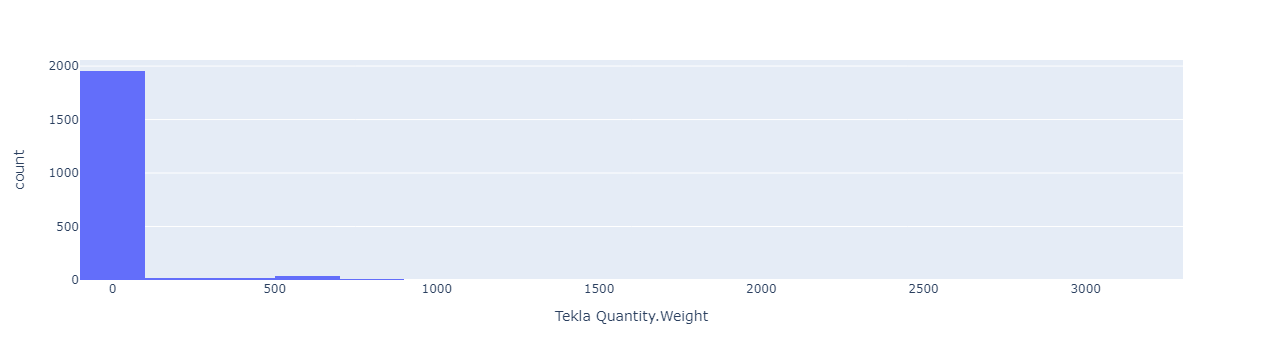

In [31]:
fig = px.histogram(df, x="Tekla Quantity.Weight", nbins=30)
fig.show()

In [11]:

def data_mean():
sample_data = pd.DataFrame({
    'income': df.sample(1000),
    'type': 'Data',
})

sample_mean_05 = pd.DataFrame({
    'income': [df.sample(5).mean() for _ in range(1000)],
    'type': 'Mean of 5',
})

sample_mean_20 = pd.DataFrame({
    'income': [df.sample(20).mean() for _ in range(1000)],
    'type': 'Mean of 20',
})

results = pd.concat([sample_data, sample_mean_05, sample_mean_20])

,Model,Year,Encoder,Task,Score
0,ERNIE,2019,Transformer,CoLA,75.5
1,T5,2019,Transformer,CoLA,71.6
2,RoBERTa,2019,Transformer,CoLA,67.8
3,BERT,2018,Transformer,CoLA,60.5
4,BiLSTM+ELMo,2018,LSTM,CoLA,32.1
...,...,...,...,...,...
59,BERT,2018,Transformer,RTE,70.1
60,BiLSTM+ELMo,2018,LSTM,RTE,57.4
61,BiLSTM+CoVe,2017,LSTM,RTE,52.7
62,BiLSTM+Attn,2017,LSTM,RTE,58.4


# Data preprocessing

In [4]:
import pandas as pd
dfr = pd.read_csv("Assignment-2_Data.csv")

In [6]:
dfr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Id         45211 non-null  int64  
 1   age        45199 non-null  float64
 2   job        45210 non-null  object 
 3   marital    45211 non-null  object 
 4   education  45211 non-null  object 
 5   default    45211 non-null  object 
 6   balance    45208 non-null  float64
 7   housing    45211 non-null  object 
 8   loan       45211 non-null  object 
 9   contact    45211 non-null  object 
 10  day        45211 non-null  int64  
 11  month      45211 non-null  object 
 12  duration   45211 non-null  int64  
 13  campaign   45211 non-null  int64  
 14  pdays      45211 non-null  int64  
 15  previous   45211 non-null  int64  
 16  poutcome   45211 non-null  object 
 17  y          45211 non-null  object 
dtypes: float64(2), int64(6), object(10)
memory usage: 6.2+ MB


In [8]:
dfr.loc[dfr.age.isna(),:]

,Id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,1001,NaN,management,married,tertiary,no,2143.0,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,1002,NaN,NaN,single,secondary,no,29.0,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,1003,NaN,entrepreneur,married,secondary,no,2.0,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
7,1008,NaN,entrepreneur,divorced,tertiary,yes,NaN,yes,no,unknown,5,may,380,1,-1,0,unknown,no
53,1054,NaN,admin.,single,secondary,no,-76.0,yes,no,unknown,5,may,787,1,-1,0,unknown,no
54,1055,NaN,technician,single,secondary,no,-103.0,yes,yes,unknown,5,may,145,1,-1,0,unknown,no
55,1056,NaN,entrepreneur,single,tertiary,no,243.0,no,yes,unknown,5,may,174,1,-1,0,unknown,no
56,1057,NaN,management,single,tertiary,no,424.0,yes,no,unknown,5,may,104,1,-1,0,unknown,no
57,1058,NaN,blue-collar,married,unknown,no,306.0,yes,no,unknown,5,may,13,1,-1,0,unknown,no
58,1059,NaN,blue-collar,single,unknown,no,24.0,yes,no,unknown,5,may,185,1,-1,0,unknown,no


In [15]:
dfr.age.fillna(dfr.age.median()) # заполнение пропусков
dfr.age.fillna(dfr.age.mean()) # заполнение пропусков

0        39.0
1        39.0
2        39.0
3        47.0
4        33.0
         ... 
45206    51.0
45207    71.0
45208    72.0
45209    57.0
45210    37.0
Name: age, Length: 45211, dtype: float64

In [17]:
dfr.education.value_counts()

secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: education, dtype: int64

In [22]:
dfr.loc[:,'day'].to_numpy()

array([ 5,  5,  5, ..., 17, 17, 17])

In [24]:
dfr.loc[dfr.duplicated(),:] # дубликатов нет

,Id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y


In [29]:
dfr.loc[dfr.duplicated(['balance','age'], keep=False),:].sort_values(by='balance')# дубликат по одной колонке 

,Id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
4913,5914,37.0,services,married,secondary,yes,-954.0,yes,no,unknown,21,may,111,3,-1,0,unknown,no
24589,25590,37.0,services,married,secondary,yes,-954.0,yes,no,cellular,17,nov,69,1,180,3,failure,no
26447,27448,36.0,unemployed,married,secondary,no,-872.0,yes,yes,cellular,20,nov,153,1,183,1,failure,no
4934,5935,36.0,unemployed,married,secondary,no,-872.0,yes,yes,unknown,21,may,153,1,-1,0,unknown,no
10616,11617,47.0,technician,married,tertiary,yes,-813.0,yes,yes,unknown,16,jun,179,25,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34154,35155,41.0,management,married,tertiary,no,27696.0,no,no,cellular,30,apr,108,1,-1,0,unknown,no
43053,44054,61.0,self-employed,divorced,tertiary,no,52587.0,no,no,cellular,15,feb,394,3,189,1,success,yes
40763,41764,61.0,self-employed,divorced,tertiary,no,52587.0,no,no,cellular,10,aug,290,1,-1,0,unknown,yes
42558,43559,84.0,retired,married,secondary,no,81204.0,no,no,telephone,28,dec,679,1,313,2,other,yes


<Axes: xlabel='education', ylabel='marital'>

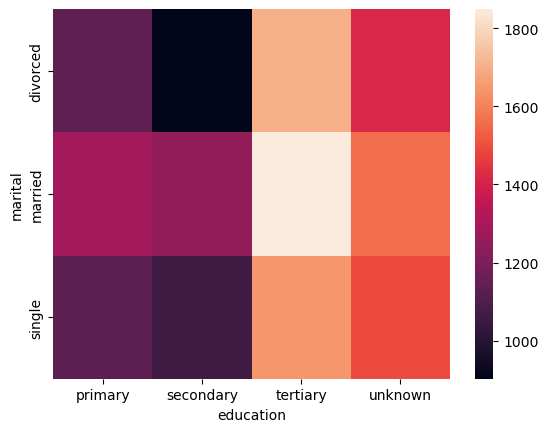

In [33]:
import seaborn as sns
sns.heatmap(dfr.pivot_table(values='balance',index='marital', columns='education',aggfunc='mean'))

In [36]:
dfr.groupby(by=['education','marital']).agg({'age':"mean", 'balance':'mean'})

age      balance
education marital                         
primary   divorced  51.494681  1137.680851
          married   46.550810  1286.877788
          single    36.689332  1131.215709
secondary divorced  44.230906   902.772647
          married   42.358414  1251.750254
          single    33.151648  1060.617443
tertiary  divorced  45.431973  1702.072789
          married   42.305287  1848.779341
          single    33.811691  1643.351210
unknown   divorced  49.295858  1417.147929
          married   48.288179  1557.787931
          single    34.671727  1493.657197